<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture8/fraud-detection-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">COMP6252 Deep Learning Technologies</h1>
<h2 style="text-align: center;"> Anomaly detection using Autoencoders</h2>

# Anomaly detection using autoencoders

In [ ]:
import torch
import torchvision as vision
import pandas as pd
import numpy as np

## The data

- The data contains 31 features. 
- Most of them are the principal components from a PCA preprocessing so we don't have a direct interpretation for those. 
- The remaining 3 are time, when the transaction occurred relative to the first one, the amount and the label to denote if the transaction was legitimate or a fraud.
- A detailed description of the dataset can be found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

- A direct quotation from that page

"The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection."

In [ ]:
import sys,os
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import files
  if not Path('/content/creditcardfraud.zip').is_file(): 
    file=files.upload() # upload the saved kaggle.json
    #### the token can be obtained from your kaggle account by going to settings
    #### in the middle of the page under API there is a create new token
    #### there is also explanation on how to do it
    %mkdir /root/.kaggle
    %mv kaggle.json  /root/.kaggle
    !kaggle datasets download -d mlg-ulb/creditcardfraud
    !unzip -q creditcardfraud.zip
else:
  #data_path=os.path.join(os.path.expanduser("~"),"Data/images_original")
  data_path="creditcard.csv"
  if not os.path.isfile(data_path):
    !kaggle datasets download -d mlg-ulb/creditcardfraud
    !unzip -q creditcardfraud.zip


## Data preprocessing


In [ ]:
df=pd.read_csv("creditcard.csv")
df

- The time feature is not used and will be dropped. 
- The "Class" column is changed to "label" since "Class" is a keyword. 

In [ ]:
df.rename(columns={'Class':'label'},inplace=True)
df=df.drop('Time',axis=1)
df

### Extremely imbalanced dataset
- The dataset contains 284315 **legitimate** samples and  492 **fraud** samples 
- This makes it extremely hard to get good results with a regression classifier
- Usually in imbalanced datasets one can either 
  - preform undersampling of the legitimate samples
  - Or perform oversampling of the fraud samples
- But this dataset is **extremely** imbalanced 

#### Anomaly detection

- An anomaly is an object different from the "norm". 
- The idea is that after training an autoencoder can reproduce "normal" input with small error. 
- An input that produces a "large" error is classified as an anomaly.
- In this notebook we will use the above idea to detect credit card fraud

#### Autoencoders

- An autoencoder is a neural networks that learns the "hidden"(latent) representation of the input. 
- The number of features of the latent representation is typically much smaller than the number of features in the input.
- This can be interpreted as dimension reduction
- An autoencoder has two parts: an **encoder**, and a **decoder**, which is typically the "inverse" of the encoder. 
- The way an autoencoder works is by learning to **reproduce** the input. 
- In the figure below, the result of learning would be to make the output as close as possible to the input

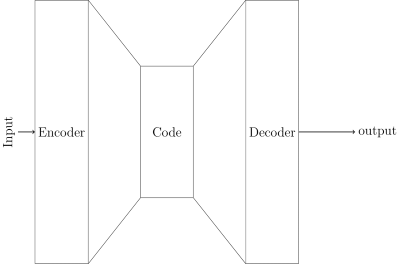

## Training
- Our aim is for the autoencoder to learn "legitimate" transactions. 
- For that end, the training is done on the non-fraud data, i.e. label=0

In [ ]:
fraud=df[df.label==1]
clean=df[df.label==0]
print("# of fraud samples {}. # of clean samples {} ".format(
            len(fraud),len(clean)))

- Training is done on the "clean" data only
- But need to retain a fraction of that "clean" data for testing later on
- Since the "clean" and "fraud" are separated we drop the "label" column

In [ ]:
TRAINING_SAMPLE=250000
clean=clean.sample(frac=1).reset_index(drop=True)
train_input=clean.iloc[:TRAINING_SAMPLE].drop('label',axis=1)
test_input=pd.concat([clean.iloc[TRAINING_SAMPLE:],fraud])
test_input.label.value_counts()

### MinMaxScaler
- The data is rescaled as we did before to help in the convergence.
- MinMaxScaler scales the data to (default) range of (0,1) as follows
- For a given vector X
\begin{align*}
X_{std} &= \frac{X - X_{min}}{X_{max} - X_{min}}\\
X_{scaled} &= X_{std} * (max - min) + min
\end{align*}

In [ ]:
from sklearn.preprocessing import MinMaxScaler

pipeline=MinMaxScaler()
pipeline.fit(train_input)
X_test, y_test = test_input.drop('label', axis=1), test_input.label
X_train_transformed = pipeline.transform(train_input)
X_test_transformed = pipeline.transform(X_test)


### Create a custom dataset
- To use the data with PyTorch we wrap it in a ```Dataset``` class

In [ ]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self,data):
        #self.data=frame.to_numpy(dtype=np.float32)        
        self.data=data
    def __getitem__(self,idx):
            return torch.as_tensor(self.data[idx],dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

train_dataset=CustomDataset(X_train_transformed)
train_loader=DataLoader(train_dataset,batch_size=256)

No attempt was made to optimize the network architecture

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super().__init__()
        # Encoder
        self.encoder=nn.Sequential(
            nn.Linear(in_features=29,out_features=16),
            activation,
            nn.Linear(in_features=16,out_features=8),
            activation,
            nn.Linear(in_features=8,out_features=4),
            activation,
            nn.Linear(in_features=4,out_features=2),
            activation
        )
        
        # Decoder
        self.decoder=nn.Sequential(
            nn.Linear(in_features=2,out_features=4),
            activation,
            nn.Linear(in_features=4,out_features=8),
            activation,
            nn.Linear(in_features=8,out_features=16),
            activation,
            nn.Linear(in_features=16,out_features=29)
        )
    def forward(self,x):
        return self.decoder(self.encoder(x))
        

In [ ]:
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm
model=Net(nn.ELU())
#model=Net(nn.Tanh())
optimizer=Adam(model.parameters())
## for regression problems typically MSELoss is used
loss_fn=MSELoss()
epochs=50
for epoch in range(epochs):
    loop=tqdm(train_loader)
    loop.set_description("Epoch [{}/{}]".format((epoch+1),epochs))
    for x in loop:
        optimizer.zero_grad()
        y=model(x)
        loss=loss_fn(x,y)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
   

## Detecting fraud

- The mse of test data is computed. 
- Because the autoencoder learned the "legitimate" transactions we consider each transaction having mse > some threshold to be fraud. 
- We **ASSUME** that the distribution is normal and a z-score >3 covers 99% of the samples

In [ ]:
# Compute the output for the training data and MSE for that output
# this will be used to establish a threshold for anomaly
train_predict=model(torch.as_tensor(X_train_transformed,dtype=torch.float32))
# mse_train is the mean square error of features per sample
# It basically measures how much the input data is different from the output data 
# A "perfect" model would have a mse_train of 0
mse_train=np.mean(np.power(X_train_transformed - train_predict.detach().numpy(), 2), axis=1)
print(mse_train.mean(),mse_train.std())

# Compute the output for the test data and MSE for that output
test_predict = model(torch.as_tensor(X_test_transformed,dtype=torch.float32))
# mse is the mean square error of features per sample for the test data
mse_test = np.mean(np.power(X_test_transformed - test_predict.detach().numpy(), 2), axis=1)

#### Visualisation of the results

- Visualise the "separation" between normal and anomaly. 
- ```y_test``` are the labels associated with each sample
- Its values are either 0 or 1

### Filtering numpy arrays

numpy arrays can be filtered by another numpy array or pandas series,

An example.

In [ ]:
s=pd.Series([0,2,7])
a=np.array([33,27,53,14,35,68,79,18,94,110])
f=np.array([1,2,9])
print(a[s])
print(a[f])

Recall ```y_test``` contains the indices and labels of test data

```y_test==i``` returns all indices for which ```label=i```

In [ ]:
import matplotlib.pyplot as plt
clean = mse_test[y_test==0]
fraud = mse_test[y_test==1]
print("num clean {}. num fraud {}".format(len(clean),len(fraud)))
fig, ax = plt.subplots(figsize=(10,6))


ax.hist(clean, bins=100, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=100, density=True, label="fraud", alpha=.6, color="red")
plt.xlim((0,0.1))
plt.title("Distribution of mean squared error")
plt.legend()
plt.xlabel("mse")
plt.ylabel("count")
plt.show()

In [ ]:
## Consider all instances that produce a z-score >3
## We are ASSUMING The mse distribution of training samples are drawn from a normal distribution

z=(mse_test-mse_train.mean())/mse_train.std()
outliers=z>3
print("num of samples classified as fraud {}".format(outliers.sum()))

from sklearn.metrics import confusion_matrix

cm= confusion_matrix(outliers,y_test)
# true/false positives/negatives
(tn, fn, fp, tp) = cm.flatten()
print(fp,fn)

In [ ]:
print("Confusion matrix \n{}".format(cm))

print("precision: tp/(tp+fp)= {:.2%}".format(tp/(fp+tp)))
print("recall: tp/(tp+fn)={:.2%}".format(tp/(fn+tp)))